<a href="https://colab.research.google.com/github/kostadubovskiy/stutternet/blob/main/stutter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
    This is an in-progress recreation of the FluentNet LSTM neural network by T. Kourkounakis et al.
    The intended use is to learn how to classify audio clips into stuttered speech or clean speech, and furthermore each subcategory of stuttered or non-stutt
"""

'\n    This is an in-progress recreation of the FluentNet LSTM neural network by T. Kourkounakis et al.\n    The intended use is to learn how to classify audio clips into stuttered speech or clean speech, and furthermore each subcategory of stuttered or non-stutt\n'

In [ ]:
#@title Install Libraries { form-width: "10%", display-mode: "form" }
# install libraries for data generation below
!pip install pydub -qU

In [ ]:
#@title Import Libraries { form-width: "10%", display-mode: "form" }
# Import libraries
#!conda info
#!conda list
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import math
import random

import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim

import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

import scipy.signal as signal
from scipy.io import wavfile
import soundfile as sf
!pip install pydub
from pydub import AudioSegment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Prepare data and utility functions. (From Pytorch documentation) { display-mode: "form" }
#@markdown You do not need to look into this cell.
#@markdown Just execute once and you are good to go.
#@markdown In this tutorial, we will use a speech data from [VOiCES dataset](https://iqtlabs.github.io/voices/), which is licensed under Creative Commos BY 4.0.


#-------------------------------------------------------------------------------
# Installation of missing packages
#-------------------------------------------------------------------------------
!pip install boto3

#-------------------------------------------------------------------------------
# Preparation of data and helper functions.
#-------------------------------------------------------------------------------
import io
import os
import math
import tarfile
import multiprocessing

import scipy
import librosa
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import requests
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import Audio, display

[width, height] = matplotlib.rcParams['figure.figsize']
if width < 10:
  matplotlib.rcParams['figure.figsize'] = [width * 2.5, height]

_SAMPLE_DIR = "_sample_data"
SAMPLE_WAV_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav"
SAMPLE_WAV_PATH = os.path.join(_SAMPLE_DIR, "steam.wav")

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

SAMPLE_RIR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/room-response/rm1/impulse/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo.wav"
SAMPLE_RIR_PATH = os.path.join(_SAMPLE_DIR, "rir.wav")

SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"
SAMPLE_NOISE_PATH = os.path.join(_SAMPLE_DIR, "bg.wav")

SAMPLE_MP3_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.mp3"
SAMPLE_MP3_PATH = os.path.join(_SAMPLE_DIR, "steam.mp3")

SAMPLE_GSM_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.gsm"
SAMPLE_GSM_PATH = os.path.join(_SAMPLE_DIR, "steam.gsm")

SAMPLE_TAR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit.tar.gz"
SAMPLE_TAR_PATH = os.path.join(_SAMPLE_DIR, "sample.tar.gz")
SAMPLE_TAR_ITEM = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

S3_BUCKET = "pytorch-tutorial-assets"
S3_KEY = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

YESNO_DATASET_PATH = os.path.join(_SAMPLE_DIR, "yes_no")
os.makedirs(YESNO_DATASET_PATH, exist_ok=True)
os.makedirs(_SAMPLE_DIR, exist_ok=True)

def _fetch_data():
  uri = [
    (SAMPLE_WAV_URL, SAMPLE_WAV_PATH),
    (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
    (SAMPLE_RIR_URL, SAMPLE_RIR_PATH),
    (SAMPLE_NOISE_URL, SAMPLE_NOISE_PATH),
    (SAMPLE_MP3_URL, SAMPLE_MP3_PATH),
    (SAMPLE_GSM_URL, SAMPLE_GSM_PATH),
    (SAMPLE_TAR_URL, SAMPLE_TAR_PATH),
  ]
  for url, path in uri:
    with open(path, 'wb') as file_:
      file_.write(requests.get(url).content)

_fetch_data()

def _download_yesno():
  if os.path.exists(os.path.join(YESNO_DATASET_PATH, "waves_yesno.tar.gz")):
    return
  torchaudio.datasets.YESNO(root=YESNO_DATASET_PATH, download=True)

YESNO_DOWNLOAD_PROCESS = multiprocessing.Process(target=_download_yesno)
YESNO_DOWNLOAD_PROCESS.start()

def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_speech_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)

def get_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_PATH, resample=resample)

def get_rir_sample(*, resample=None, processed=False):
  rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
  if not processed:
    return rir_raw, sample_rate
  rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
  rir = rir / torch.norm(rir, p=2)
  rir = torch.flip(rir, [1])
  return rir, sample_rate

def get_noise_sample(*, resample=None):
  return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def inspect_file(path):
  print("-" * 10)
  print("Source:", path)
  print("-" * 10)
  print(f" - File size: {os.path.getsize(path)} bytes")
  print(f" - {torchaudio.info(path)}")

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)

def get_spectrogram(
    n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
):
  waveform, _ = get_speech_sample()
  spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
  )
  return spectrogram(waveform)

def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)

def plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Kaldi Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label='Pitch', color='green')
  axis.set_ylim((-1.3, 1.3))

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, nfcc.shape[1])
  ln2 = axis2.plot(
      time_axis, nfcc[0], linewidth=2, label='NFCC', color='blue', linestyle='--')

  lns = ln1 + ln2
  labels = [l.get_label() for l in lns]
  axis.legend(lns, labels, loc=0)
  plt.show(block=False)

DEFAULT_OFFSET = 201
SWEEP_MAX_SAMPLE_RATE = 48000
DEFAULT_LOWPASS_FILTER_WIDTH = 6
DEFAULT_ROLLOFF = 0.99
DEFAULT_RESAMPLING_METHOD = 'sinc_interpolation'

def _get_log_freq(sample_rate, max_sweep_rate, offset):
  """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

  offset is used to avoid negative infinity `log(offset + x)`.

  """
  half = sample_rate // 2
  start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
  return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset

def _get_inverse_log_freq(freq, sample_rate, offset):
  """Find the time where the given frequency is given by _get_log_freq"""
  half = sample_rate // 2
  return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))

def _get_freq_ticks(sample_rate, offset, f_max):
  # Given the original sample rate used for generating the sweep,
  # find the x-axis value where the log-scale major frequency values fall in
  time, freq = [], []
  for exp in range(2, 5):
    for v in range(1, 10):
      f = v * 10 ** exp
      if f < sample_rate // 2:
        t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
        time.append(t)
        freq.append(f)
  t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
  time.append(t_max)
  freq.append(f_max)
  return time, freq

def plot_sweep(waveform, sample_rate, title, max_sweep_rate=SWEEP_MAX_SAMPLE_RATE, offset=DEFAULT_OFFSET):
  x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
  y_ticks = [1000, 5000, 10000, 20000, sample_rate//2]

  time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
  freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
  freq_y = [f for f in freq if f >= 1000 and f in y_ticks and f <= sample_rate // 2]

  figure, axis = plt.subplots(1, 1)
  axis.specgram(waveform[0].numpy(), Fs=sample_rate)
  plt.xticks(time, freq_x)
  plt.yticks(freq_y, freq_y)
  axis.set_xlabel('Original Signal Frequency (Hz, log scale)')
  axis.set_ylabel('Waveform Frequency (Hz)')
  axis.xaxis.grid(True, alpha=0.67)
  axis.yaxis.grid(True, alpha=0.67)
  figure.suptitle(f'{title} (sample rate: {sample_rate} Hz)')
  plt.show(block=True)

def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal

def benchmark_resample(
    method,
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=DEFAULT_LOWPASS_FILTER_WIDTH,
    rolloff=DEFAULT_ROLLOFF,
    resampling_method=DEFAULT_RESAMPLING_METHOD,
    beta=None,
    librosa_type=None,
    iters=5
):
  if method == "functional":
    begin = time.time()
    for _ in range(iters):
      F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                 rolloff=rolloff, resampling_method=resampling_method)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "transforms":
    resampler = T.Resample(sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                           rolloff=rolloff, resampling_method=resampling_method, dtype=waveform.dtype)
    begin = time.time()
    for _ in range(iters):
      resampler(waveform)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "librosa":
    waveform_np = waveform.squeeze().numpy()
    begin = time.time()
    for _ in range(iters):
      librosa.resample(waveform_np, sample_rate, resample_rate, res_type=librosa_type)
    elapsed = time.time() - begin
    return elapsed / iters

In [ ]:
# File reading for spectrograms from the .FLAC files
data, samplerate = sf.read("/content/drive/MyDrive/Work/MCRL/stutter/data/libristutter/partA/audio/103/1240/103-1240-0000.flac")

# Read CSV annotations
df1 = pd.read_csv('/content/drive/MyDrive/Work/MCRL/stutter/data/libristutter/partA/annotations/103/1240/103-1240-0000.csv')

In [ ]:
waveform, sample_rate = torchaudio.load("/content/drive/MyDrive/Work/MCRL/stutter/data/uclass/audio/F_0050_10y9m_1.wav")

print_stats(waveform, sample_rate=16000)
#plot_waveform(waveform, sample_rate)
plot_specgram(waveform, 16000)
play_audio(waveform, 16000)
"""
waveform, sample_rate = torchaudio.load("/content/drive/MyDrive/Work/MCRL/stutter/data/libristutter/partA/audio/103/1240/103-1240-0000.flac")

print_stats(waveform, sample_rate=sample_rate)
#plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)"""

RuntimeError: ignored

In [ ]:
#@title Libristutter —ALL APPEARANCES— Data Generation, Storage { form-width: "10%" }
# Libristutter audio file --> audio clips(the 4 seconds around all appearances of stutters) --> spectrogram --> storage
# all images saved to "/contents/data/images/" in google drive root
def graph_spectrogram(wav_file):
    rate, data = wavfile.read(wav_file)
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    pxx, freqs, bins, im = ax.specgram(x=data, Fs=16000, noverlap=128, NFFT=256)
    ax.axis('off')
    #fig.savefig('sp_xyz.png', dpi=300, frameon='false')


data_location = "/content/drive/MyDrive/Work/MCRL/stutter/data/libristutter/"
parts = ['partC'] #['partA', 'partB', 'partC']


#!rm -r /content/drive/MyDrive/Work/MCRL/stutter/data/libristutter/clips
#!rm -r /content/drive/MyDrive/data/imagesA/
#!rm -r /content/drive/MyDrive/data/imagesB/
#!rm -r /content/drive/MyDrive/data/imagesC/

for part in parts:
  speakerIDs = sorted(os.listdir(data_location + part + "/" + "audio/")) # speaker ID numbers array
  speakerIDNum = speakerIDs.index('87') #0 # math.ceil(0.8 * (len(speakerIDs)-1)) # this convoluted to start with j test data creation, normally 0
  speakerID = speakerIDs[speakerIDNum]
  for id in speakerIDs: print(id)

  chapters = sorted(os.listdir(data_location + part + "/" + "audio/" + speakerID)) # chapter numbers array
  chapterNum = 0 #math.ceil(0.8 * (len(chapters)-1)) # 0
  chapter = chapters[chapterNum]

  phrases = sorted(os.listdir(data_location + part + "/" + "audio" + "/" + speakerID + "/" + chapter)) # audio file names array (all .flac)
  phraseNum = 0#math.ceil(0.8 * (len(phrases)-1)) # 0
  phrase = phrases[phraseNum]

  annotation_name = phrase[:-5] + ".csv"
  annotation_location = data_location + part + "/" + "annotations/" + speakerID + "/" + chapter + "/" + annotation_name


  train_location = f"/content/drive/MyDrive/data/{'images' + part[-1]}/train/"
  test_location = f"/content/drive/MyDrive/data/{'images' + part[-1]}/test/"
  clips_location = "/content/drive/MyDrive/Work/MCRL/stutter/data/libristutter/clips/"

  dataTrainPctg = 0.8

  partition_spec_loc = train_location # swaps to test_location when 80% of data has been put in train/
  lump_loc = "/content/drive/MyDrive/data/libriAll/"
  lump_spec_loc = lump_loc + "train/"

  while speakerIDNum < len(speakerIDs): # first 80% of speakers is for training
    print("\nCREATING TRAINING IMAGES\n")
    while chapterNum < len(chapters):
      while phraseNum < len(phrases):
        if speakerIDNum > len(speakerIDs) * dataTrainPctg and partition_spec_loc != test_location:
          partition_spec_loc = test_location
          lump_spec_loc = lump_loc + "test/"
          print("""\n\n\nDONE WITH CREATING TRAINING IMAGES\nCREATING TESTING IMAGES\n\n\n""")
        
        file_name = phrase
        file_location = data_location + part + "/" + "audio/" + speakerID + "/" + chapter + "/" + file_name

        annotation_name = phrase[:-5] + ".csv"
        annotation_location = data_location + part + "/" + "annotations/" + speakerID + "/" + chapter + "/" + annotation_name
        stutterRows = []

        with open(annotation_location, newline='') as csvfile: # open annotations for current file
        
          spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
          data = list(spamreader)
          rowCount = len(data)
          stutterRowInd = 0
          foundStutters = 0

          print(f'Loc: {file_location}')
          for row in data: # finds first appearance of stutter in the csv annotation just opened and stores that row in stutterRows
            row = row[0].split(",")
            if len(row) == 4 and row[3] != '0':
              stutterRows.append(row)
              for cellInd in range(len(stutterRows[foundStutters])): 
                if cellInd > 0: 
                  stutterRows[foundStutters][cellInd] = float(stutterRows[foundStutters][cellInd])
                cellInd += 1
              print(f'  Row: {str(row[0])}, {str(int(row[3]))}, {str(row[1])}, {str(row[2])}') # STUTTER, TYPE, START, END
              foundStutters += 1
            stutterRowInd += 1
            
        csvfile.close()
        print(f'  StutterRows: {stutterRows}')
        audio = AudioSegment.from_file(file_location) # create audiosegment object from the full .flac file
        if audio.duration_seconds * 1000 >= 4000:
          if len(stutterRows) == 0: # if file had no stutters
            print(f'\nCLEAN FOUND @: {file_location}\n')
            full_length = int(audio.duration_seconds *  1000)
            cleanInd = 0
            for cleanChunk in range(math.floor(audio.duration_seconds * 1000 / 4000)):
              cleanInd += 1
              print(f'  Creating {cleanInd} clean clip here')
              cleanStart = cleanChunk * 4000
              cleanEnd = cleanStart + 4000
              stutterType = 0
              stutterClip = audio[cleanStart:cleanEnd]
              print(f'    Stutter-Free Clip Start and End: {cleanStart}, {cleanEnd}')

              clipName = clips_location + part + "/" + file_name[:-5] + "_" + str(cleanInd) + ".flac"
              exportClip = AudioSegment.empty() # only way I know how to do this at the moment, make a new empty audioseg, append the stutter clip to it w/ no fade-in
              exportClip = exportClip.append(stutterClip, crossfade = 0)
              os.makedirs(os.path.dirname(clipName), exist_ok=True) # in case it doesn't exist, create the dir where image will be stored
              exportClip.export(clipName, format="wav")

              # spectrogram creation
              file_part_name = partition_spec_loc + str(stutterType) + "/" + file_name[:-5]  + "_" + str(cleanInd) + ".png" # strip .flac and direct images to content/data/[STUTTER TYPE]/[FILE NAME]
              file_lump_name = lump_spec_loc + str(stutterType) + "/" + file_name[:-5] + "_" + str(cleanInd) + ".png"
              os.makedirs(os.path.dirname(file_part_name), exist_ok=True) # in case it doesn't exist, create the dir where image will be stored
              os.makedirs(os.path.dirname(file_lump_name), exist_ok=True) # in case it doesn't exist, create the dir where image will be stored
              
              graph_spectrogram(clipName) # graph, save, close
              plt.savefig(file_part_name)
              plt.savefig(file_lump_name)
              plt.close()
            csvfile.close()

          else: # if the file had stutters
            rowInd = 0
            for stutterRow in stutterRows:
              audio = AudioSegment.from_file(file_location) # create audiosegment object from the full .flac file
              rowInd += 1
              stutterStart = stutterRow[1] * 1000 # convert to milliseconds for pydub AudioSegment module
              stutterEnd = stutterRow[2] * 1000
              stutterDurr = stutterEnd - stutterStart
              timeLeft = 4000 - stutterDurr
              halfLeft = timeLeft / 2
              stutterType = int(stutterRow[3])
              start = 0
              end = 4000
              #print(f'    Stutter Clip init Start and End: {stutterStart}, {stutterEnd}')
              #print(f'    Half left: {halfLeft}')

              if timeLeft >= 0: # if we need to add time to the clip to make it 4 seconds long
                # here we know the amount we'd half to add to each side of the clip to make it 4 seconds long(halfLeft)
                # and we are checking if we can take of that amount without going outside the bounds of the whole clip
                # if we go out of them as in the first two ifs, then that means we are either at the end or the start
                # in those cases, take the first 4 seconds or the last 4, respectively
                # otherwise take the clip from start-halfLeft to end+halfLeft
                if stutterStart - halfLeft < 0: # if the stutter is within the first 4 seconds
                  start = 0
                elif stutterEnd + halfLeft > audio.duration_seconds * 1000: # if the stutter is within the last 4 seconds
                  start = audio.duration_seconds * 1000 - 4000
                else: # if it's after the first 4 seconds and before the last 4
                  start = stutterStart - halfLeft

              end = start + 4000
              stutterClip = audio[start:end]
              print(f'    Stutter clip {rowInd} duration: start, end: ({start}, {end}); len: {stutterClip.duration_seconds * 1000}')

              clipName = clips_location + part + "/" + file_name[:-5] + "_" + str(rowInd) + ".flac"
              exportClip = AudioSegment.empty() # only way I know how to do this at the moment, make a new empty audioseg, append the stutter clip to it w/ no fade-in
              exportClip = exportClip.append(stutterClip, crossfade = 0)
              os.makedirs(os.path.dirname(clipName), exist_ok=True) # in case it doesn't exist, create the dir where image will be stored
              exportClip.export(clipName, format="wav")

              # spectrogram creation
              file_part_name = partition_spec_loc + str(stutterType) + "/" + file_name[:-5]  + "_" + str(rowInd) + ".png" # strip .flac and direct images to content/data/[STUTTER TYPE]/[FILE NAME]
              file_lump_name = lump_spec_loc + str(stutterType) + "/" + file_name[:-5] + "_" + str(rowInd) + ".png"
              os.makedirs(os.path.dirname(file_part_name), exist_ok=True) # in case it doesn't exist, create the dir where image will be stored
              os.makedirs(os.path.dirname(file_lump_name), exist_ok=True) # in case it doesn't exist, create the dir where image will be stored
              
              graph_spectrogram(clipName) # graph, save, close
              plt.savefig(file_part_name)
              plt.savefig(file_lump_name)
              plt.close()
        else:
          print(f'\nFile at {file_location} is not at least 4 seconds. SKIPPED\n')

        phraseNum += 1
        if phraseNum < len(phrases):
          phrase = phrases[phraseNum]

      chapterNum += 1 # once we've finished all the phrases for a chapter
      if chapterNum < len(chapters): # move onto the next chapter for this speaker if it exists
        chapter = chapters[chapterNum]
        phrases = sorted(os.listdir(data_location + part + "/" + "audio" + "/" + speakerID + "/" + chapter)) # fetch the new phrases
        phraseNum = 0
        phrase = phrases[phraseNum]
      
    speakerIDNum += 1
    if speakerIDNum < len(speakerIDs):
      speakerID = speakerIDs[speakerIDNum]
    chapterNum = 0
    chapters = sorted(os.listdir(data_location + part + "/" + "audio/" + speakerID))
    chapter = chapters[chapterNum]
    phrases = sorted(os.listdir(data_location + part + "/" + "audio" + "/" + speakerID + "/" + chapter)) # fetch the new phrases
    phraseNum = 0
    phrase = phrases[phraseNum]

6000
625
6437
6925
7067
7113
7517
7780
78
8095
8098
8238
831
8468
87
8975

CREATING TRAINING IMAGES




DONE WITH CREATING TRAINING IMAGES
CREATING TESTING IMAGES



Loc: /content/drive/MyDrive/Work/MCRL/stutter/data/libristutter/partC/audio/87/121553/87-121553-0000.flac
  Row: STUTTER, 2, 3.2, 3.8364172335600903
  StutterRows: [['STUTTER', 3.2, 3.8364172335600903, 2.0]]
    Stutter clip 1 duration: start, end: (1518.208616780045, 5518.208616780045); len: 4000.0
Loc: /content/drive/MyDrive/Work/MCRL/stutter/data/libristutter/partC/audio/87/121553/87-121553-0001.flac
  Row: STUTTER, 2, 2.8, 3.1539682539682525
  Row: STUTTER, 2, 4.853968253968253, 5.229070294784579
  StutterRows: [['STUTTER', 2.8, 3.1539682539682525, 2.0], ['STUTTER', 4.853968253968253, 5.229070294784579, 2.0]]
    Stutter clip 1 duration: start, end: (976.9841269841263, 4976.984126984126); len: 4000.0
    Stutter clip 2 duration: start, end: (3041.519274376416, 7041.519274376416); len: 4000.0
Loc: /content/drive/MyDrive

In [ ]:
def graph_spectrogram(wav_file):
    rate, data = wavfile.read(wav_file)
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    pxx, freqs, bins, im = ax.specgram(x=data, Fs=16000, noverlap=128, NFFT=256)
    ax.axis('off')
    #fig.savefig('/content/example.png',, frameon='false')

print(f'0-class Image Before and After Clipping')
graph_spectrogram("/content/drive/MyDrive/Work/MCRL/stutter/data/libristutter/partB/audio/2952/407/2952-407-0021.flac")
graph_spectrogram("/content/drive/MyDrive/Work/MCRL/stutter/data/libristutter/clips/partB/2952-407-0021_1.flac")
#print(f'x-class Image Before and After Clipping')
#graph_spectrogram("/content/drive/MyDrive/Work/MCRL/stutter/data/libristutter/partA/audio/103/1240/103-1240-0000.flac")
#graph_spectrogram("/content/drive/MyDrive/Work/MCRL/stutter/data/libristutter/clips/partA/103-1240-0000_1.flac")

In [ ]:
#@title UCLASS Data Generation -- ALL APPEARANCES { form-width: "10%", display-mode: "form" }
# UCLASS audio file --> audio clip(the 4 seconds around the first appearance of a stutter) --> spectrogram --> storage
# all images saved to "/contents/data/Uimages/" in google drive root
# aud_~~ = audio, annot_~~ = annotation, file_~~ = spectrogram
def graph_spectrogram(wav_file):
    rate, data = wavfile.read(wav_file)
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    pxx, freqs, bins, im = ax.specgram(x=data, Fs=16000, noverlap=128, NFFT=256) # NFFT used to be 512, worked well supposedly 
    ax.axis('off')
    #fig.savefig('sp_xyz.png', dpi=300, frameon='false')


data_location = "/content/drive/MyDrive/Work/MCRL/stutter/data/uclass/"
annotation_location = data_location + "annotations/"
audio_location = data_location + "audio/"

annot_files = sorted(os.listdir(data_location + "annotations/"))

train_location = "/content/drive/MyDrive/data/uimages/train/"
test_location = "/content/drive/MyDrive/data/uimages/test/"
clips_location = "/content/drive/MyDrive/Work/MCRL/stutter/data/uclass/clips/"

!rm -r /content/drive/MyDrive/data/uimages/
!rm -r /content/drive/MyDrive/Work/MCRL/stutter/data/uclass/clips/

part_spec_location = train_location

print("\nCREATING UCLASS VALIDATION IMAGES\n")
file_num = 1
pct_for_train = 0.8

for annot_name in annot_files:
  if file_num > len(annot_files) * pct_for_train and part_spec_location != test_location:
    part_spec_location = test_location
    print("""\n\n\nDONE WITH CREATING TRAINING IMAGES\nCREATING TESTING IMAGES\n\n\n""")

  curr_annot_location = annotation_location + annot_name
  audio_name = annot_name[:-4] + ".flac"
  curr_audio_location = audio_location + audio_name
  stutterRows = []
  print(f"\nStutter(s) @ file {file_num}'s Loc: {curr_annot_location}")
  file_num += 1

  with open(curr_annot_location, newline='', encoding='cp1252') as csvfile: # open annotations for current file
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    #print(spamreader)
    data = list(spamreader)
    rowCount = len(data)
    stutterRowInd = 0
    foundStutters = 0
    for row in data: # finds all rows indicated to contain a stutter and stores them in stutterRows
      if row[7] != '0': # the 5th box contains boolean indicating a stutter or lack thereof
        file_cont_st = True
        stutterRows.append(row) # add the row containining the stutter
        for cellInd in [2, 3]: 
          stutterRows[foundStutters][cellInd] = float(stutterRows[foundStutters][cellInd]) # turn the numerical values in the csv boxes from strings into floats
        for cellInd in [7]:
          stutterRows[foundStutters][cellInd] = int(stutterRows[foundStutters][cellInd])
        print(f'  Row {stutterRowInd}: {str(stutterRows[foundStutters])}')
        foundStutters += 1
      stutterRowInd += 1
  
  csvfile.close()

  if len(stutterRows) != 0: # if it had stutters, loop through each stutter-containing row
    rowInd = 0
    prevStutterEnd = stutterRows[0][3] * 1000
    cleanGaps = 0
    for stutterRow in stutterRows:
      audio = AudioSegment.from_file(curr_audio_location) # create audiosegment object from the full .flac file
      rowInd += 1
      stutterStart = stutterRow[2] * 1000 # convert to milliseconds for pydub AudioSegment module
      stutterEnd = stutterRow[3] * 1000
      stutterDurr = stutterEnd - stutterStart
      timeLeft = 4000 - stutterDurr
      halfLeft = timeLeft / 2
      stutterType = int(stutterRow[7])

      if stutterStart - prevStutterEnd > 4000:
        cleanGaps += 1
        for chunkInd in range(math.floor((stutterStart - prevStutterEnd)/4000)):
          start = stutterStart + chunkInd * 4000
          end = start + 4000
          stutterClip = audio[start: end]
          print(f'      Clean UCLASS inter-clip {chunkInd + 1} range: ({start}, {end}); len: {stutterClip.duration_seconds * 1000}')

          clip_name = f"{clips_location}/{audio_name[:-4]}_{cleanGaps}clean{chunkInd}.flac" # data/uimages/clips/~~~~~.wav (the 4 second audio clip files)
          exportClip = AudioSegment.empty() # only way I know how to do this at the moment, make a new empty audioseg, append the stutter clip to it w/ no fade-in
          exportClip = exportClip.append(stutterClip, crossfade = 0)
          os.makedirs(os.path.dirname(clip_name), exist_ok=True) # in case it doesn't exist, create the dir where image will be stored
          exportClip.export(clip_name, format="wav")

          # spectrogram creation
          file_result_name = f"{part_spec_location}0/{audio_name[:-4]}_{cleanGaps}clean{rowInd}.png" # strip .wav and direct images to content/data/[STUTTER TYPE]/[FILE NAME]
          os.makedirs(os.path.dirname(file_result_name), exist_ok=True) # in case it doesn't exist, create the dir where image will be stored
          
          #print(f'Clip name: {clip_name}')
          graph_spectrogram(clip_name) # graph, save, close # used to be file_location
          plt.savefig(file_result_name)
          plt.close()

      if timeLeft >= 0: # if we need to add time to the clip to make it 4 seconds long
        # here we know the amount we'd half to add to each side of the clip to make it 4 seconds long(halfLeft)
        # and we are checking if we can take of that amount without going outside the bounds of the whole clip
        # if we go out of them as in the first two ifs, then that means we are either at the end or the start
        # in those cases, take the first 4 seconds or the last 4, respectively
        # otherwise take the clip from start-halfLeft to end+halfLeft
        if stutterStart - halfLeft < 0: # if the stutter is within the first 4 seconds
          start = 0
          end = 4000
        elif stutterEnd + halfLeft > audio.duration_seconds * 1000: # if the stutter is within the last 4 seconds
          start = audio.duration_seconds * 1000 - 4000
          end = start + 4000
        else: # if it's after the first 4 seconds and before the last 4
          start = stutterStart - halfLeft
          end = stutterEnd + halfLeft

      stutterClip = audio[start:end]
      print(f'    Stutter clip {rowInd} range: ({start}, {end}); len: {stutterClip.duration_seconds * 1000}')

      clip_name = clips_location + "/" + audio_name[:-4] + "_" + str(rowInd) + ".flac" # data/uimages/clips/~~~~~.wav (the 4 second audio clip files)
      exportClip = AudioSegment.empty() # only way I know how to do this at the moment, make a new empty audioseg, append the stutter clip to it w/ no fade-in
      exportClip = exportClip.append(stutterClip, crossfade = 0)
      os.makedirs(os.path.dirname(clip_name), exist_ok=True) # in case it doesn't exist, create the dir where image will be stored
      exportClip.export(clip_name, format="wav")

      # spectrogram creation
      file_result_name = part_spec_location + str(stutterType) + "/" + audio_name[:-4] + "_" + str(rowInd) + ".png" # strip .wav and direct images to content/data/[STUTTER TYPE]/[FILE NAME]
      os.makedirs(os.path.dirname(file_result_name), exist_ok=True) # in case it doesn't exist, create the dir where image will be stored
      
      #print(f'Clip name: {clip_name}')
      graph_spectrogram(clip_name) # graph, save, close # used to be file_location
      plt.savefig(file_result_name)
      plt.close()

      prevStutterEnd = stutterEnd


rm: cannot remove '/content/drive/MyDrive/data/uimages/': No such file or directory
rm: cannot remove '/content/drive/MyDrive/Work/MCRL/stutter/data/uclass/clips/': No such file or directory

CREATING UCLASS VALIDATION IMAGES


Stutter(s) @ file 1's Loc: /content/drive/MyDrive/Work/MCRL/stutter/data/uclass/annotations/F_0101_10y4m_1.csv
  Row 6: ['UM', 'UM', 6.0, 6.43, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 7: ['IN', 'in', 6.51, 6.79, 'TRUE', 'FALSE', 'TRUE', 4]
  Row 8: ['I', 'i', 6.8, 6.81, 'TRUE', 'FALSE', 'TRUE', 4]
  Row 9: ['IN', 'in', 6.82, 7.23, 'TRUE', 'FALSE', 'TRUE', 4]
  Row 11: ['UM', 'UM', 8.83, 9.32, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 16: ['UM', 'UM', 17.0, 17.4, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 19: ['UM', 'UM', 23.76, 23.88, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 23: ['FU', 'fu', 25.34, 25.4, 'TRUE', 'FALSE', 'TRUE', 2]
  Row 24: ['FUNNY', 'funny', 25.62, 26.01, 'TRUE', 'FALSE', 'TRUE', 2]
  Row 25: ['UM', 'UM', 30.12, 30.37, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 30: ['UM', 'UM', 32.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=0).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Wa

    Stutter clip 17 range: (112665.0, 116665.0); len: 4000.0

Stutter(s) @ file 4's Loc: /content/drive/MyDrive/Work/MCRL/stutter/data/uclass/annotations/M_0030_12y1m_1.csv
  Row 10: ['UM', 'um', 3.44, 3.88, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 15: ['UM', 'um', 6.17, 6.85, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 39: ['UM', 'um', 16.31, 16.9, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 40: ['UM', 'um', 21.42, 21.85, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 45: ['UM', 'um', 26.309999, 26.589999, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 70: ['U', 'u', 35.08, 35.26, 'TRUE', 'FALSE', 'TRUE', 2]
  Row 71: ['USER', 'user', 35.35, 35.71, 'TRUE', 'FALSE', 'TRUE', 2]
  Row 78: ['UM', 'um', 38.96, 39.67, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 93: ['UM', 'um', 44.95, 45.4, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 110: ['UM', 'um', 51.5, 52.15, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 111: ['yeah', 'yeah', 53.18, 53.42, 'FALSE', 'FALSE', 'FALSE', 1]
  Row 123: ['UM', 'um', 59.52, 60.0, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 130: ['F', 'f', 61.36, 61.64, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=0).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Wa

      Clean UCLASS inter-clip 3 range: (127599.999, 131599.999); len: 0.0
    Stutter clip 34 range: (117754.999, 121754.999); len: 4000.0
    Stutter clip 35 range: (117995.0, 121995.0); len: 4000.0
    Stutter clip 36 range: (118253.0612244898, 122253.0612244898); len: 3999.9319727891157
    Stutter clip 37 range: (118253.0612244898, 122253.0612244898); len: 3999.9319727891157
    Stutter clip 38 range: (118253.0612244898, 122253.0612244898); len: 3999.9319727891157
    Stutter clip 39 range: (118253.0612244898, 122253.0612244898); len: 3999.9319727891157

Stutter(s) @ file 11's Loc: /content/drive/MyDrive/Work/MCRL/stutter/data/uclass/annotations/M_0095_08y10m_1.csv
  Row 0: ['MAA', '<unk>', 5.58, 6.09, 'TRUE', 'FALSE', 'TRUE', 6]
  Row 1: ['PLI', '', 6.09, 6.15, 'TRUE', 'FALSE', 'TRUE', 6]
  Row 11: ['AA', '<unk>', 9.51, 9.52, 'TRUE', 'FALSE', 'TRUE', 2]
  Row 12: ['AND', 'and', 9.56, 10.0, 'TRUE', 'FALSE', 'TRUE', 2]
  Row 13: ['W', 'w', 10.629999, 10.699999, 'TRUE', 'FALSE', 'TRU

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


    Stutter clip 2 range: (4120.0, 8120.0); len: 4000.0
    Stutter clip 3 range: (7515.0, 11515.0); len: 4000.0
    Stutter clip 4 range: (7780.0, 11780.0); len: 4000.0
    Stutter clip 5 range: (8664.999, 12664.999); len: 4000.0
    Stutter clip 6 range: (8889.999, 12889.999); len: 4000.0
    Stutter clip 7 range: (9759.999, 13759.999); len: 4000.0
    Stutter clip 8 range: (10554.999, 14554.999); len: 4000.0
    Stutter clip 9 range: (11020.0, 15020.0); len: 4000.0
    Stutter clip 10 range: (11519.999, 15519.999); len: 4000.0
    Stutter clip 11 range: (12084.999, 16084.999); len: 4000.0
    Stutter clip 12 range: (12375.0, 16375.0); len: 4000.0
    Stutter clip 13 range: (12779.999, 16779.999); len: 4000.0
      Clean UCLASS inter-clip 1 range: (29780.0, 33780.0); len: 4000.0
      Clean UCLASS inter-clip 2 range: (33780.0, 37780.0); len: 4000.0
      Clean UCLASS inter-clip 3 range: (37780.0, 41780.0); len: 4000.0
    Stutter clip 14 range: (27820.0, 31820.0); len: 4000.0
      C

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=0).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Wa

      Clean UCLASS inter-clip 3 range: (135619.999, 139619.999); len: 0.0
      Clean UCLASS inter-clip 4 range: (139619.999, 143619.999); len: 0.0
    Stutter clip 37 range: (125934.9995, 129934.9995); len: 4000.0
    Stutter clip 38 range: (127205.0, 131205.0); len: 4000.0

Stutter(s) @ file 12's Loc: /content/drive/MyDrive/Work/MCRL/stutter/data/uclass/annotations/M_0098_07y8m_1.csv
  Row 0: ['POO', 'poo', 1.2, 1.47, 'TRUE', 'FALSE', 'TRUE', 2]
  Row 1: ['poo', 'poo', 1.47, 1.62, 'FALSE', 'FALSE', 'FALSE', 2]
  Row 2: ['put', 'put', 1.62, 1.8, 'FALSE', 'FALSE', 'FALSE', 2]
  Row 6: ['e', 'e', 3.24, 3.25, 'FALSE', 'FALSE', 'FALSE', 2]
  Row 7: ['and', 'and', 3.9, 4.22, 'FALSE', 'FALSE', 'FALSE', 2]
  Row 9: ['UM', 'um', 4.84, 5.17, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 11: ['TEE', 'tee', 8.84, 9.08, 'TRUE', 'FALSE', 'TRUE', 2]
  Row 12: ['tried', 'tried', 9.34, 9.64, 'FALSE', 'FALSE', 'FALSE', 2]
  Row 17: ['UM', 'um', 10.679999, 10.699999, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 27: ['HHH', '

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


    Stutter clip 2 range: (0, 4000); len: 4000.0


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


    Stutter clip 3 range: (0, 4000); len: 4000.0


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


    Stutter clip 4 range: (1245.0, 5245.0); len: 4000.0
    Stutter clip 5 range: (2060.0, 6060.0); len: 4000.0
    Stutter clip 6 range: (3005.0, 7005.0); len: 4000.0
    Stutter clip 7 range: (6960.0, 10960.0); len: 4000.0
    Stutter clip 8 range: (7490.0, 11490.0); len: 4000.0
    Stutter clip 9 range: (8689.999, 12689.999); len: 4000.0
    Stutter clip 10 range: (12725.0, 16725.0); len: 4000.0
    Stutter clip 11 range: (12949.999, 16949.999); len: 4000.0
    Stutter clip 12 range: (13194.999, 17194.999); len: 4000.0
    Stutter clip 13 range: (14780.0, 18780.0); len: 4000.0
    Stutter clip 14 range: (14919.999000000002, 18919.999000000003); len: 4000.0
    Stutter clip 15 range: (15719.999, 19719.999); len: 4000.0
    Stutter clip 16 range: (18240.0, 22240.0); len: 4000.0
    Stutter clip 17 range: (18535.0, 22535.0); len: 4000.0
    Stutter clip 18 range: (18975.0, 22975.0); len: 4000.0
    Stutter clip 19 range: (20975.0, 24975.0); len: 4000.0
    Stutter clip 20 range: (21300

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=0).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Wa


Stutter(s) @ file 15's Loc: /content/drive/MyDrive/Work/MCRL/stutter/data/uclass/annotations/M_0100_11y2m_1.csv
  Row 0: ['UM', 'UM', 0.01, 0.17, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 1: ['U', 'u', 0.18, 0.2, 'TRUE', 'FALSE', 'TRUE', 1]
  Row 30: ['UM', 'UM', 22.08, 22.69, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 31: ['ER', 'er', 24.81, 25.02, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 59: ['UM', 'UM', 49.92, 50.38, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 65: ['UM', 'UM', 54.92, 55.41, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 70: ['UM', 'UM', 61.83, 62.13, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 71: ['ER', 'er', 62.13, 62.14, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 78: ['UM', 'UM', 75.65, 75.93, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 79: ['M', 'm', 77.04, 77.23, 'TRUE', 'FALSE', 'TRUE', 1]
  Row 83: ['UM', 'UM', 83.41, 83.8, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 96: ['UM', 'UM', 99.0, 99.02, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 102: ['S', 's', 106.53, 106.55, 'TRUE', 'FALSE', 'TRUE', 2]
  Row 103: ['U', 'u', 106.55, 106.57, 'TRUE', 'FALSE',

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=0).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Wa


Stutter(s) @ file 23's Loc: /content/drive/MyDrive/Work/MCRL/stutter/data/uclass/annotations/M_0394_09y2m_1.csv
  Row 0: ['UM', 'UM', 1.76, 1.78, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 15: ['UM', 'UM', 9.65, 10.05, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 24: ['SSSOAwiming', '<unk>', 15.82, 16.2, 'FALSE', 'FALSE', 'FALSE', 7]
  Row 37: ['UM', 'UM', 24.22, 24.6, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 45: ['UM', 'UM', 29.19, 29.65, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 49: ['M', '', 30.76, 30.759999, 'TRUE', 'FALSE', 'TRUE', 2]
  Row 51: ['MA', 'ma', 31.41, 31.43, 'TRUE', 'FALSE', 'TRUE', 2]
  Row 52: ['MELTED', 'melted', 31.44, 31.94, 'TRUE', 'FALSE', 'TRUE', 2]
  Row 55: ['F', 'f', 32.48, 32.51, 'TRUE', 'FALSE', 'TRUE', 2]
  Row 56: ['FAVOUROTE', '<unk>', 32.71, 33.01, 'TRUE', 'FALSE', 'TRUE', 2]
  Row 64: ['UM', 'UM', 34.77, 35.13, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 79: ['ER', 'ER', 43.66, 43.75, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 82: ['ER', 'ER', 48.46, 48.69, 'TRUE', 'TRUE', 'FALSE', 1]
  Row 83: ['i', '

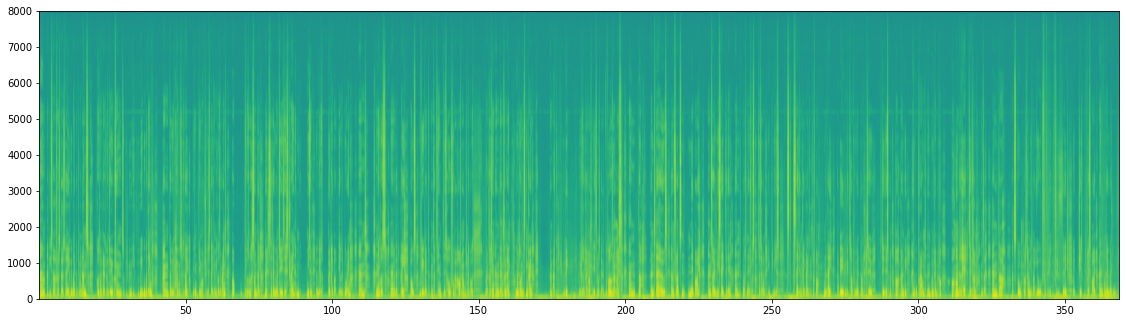

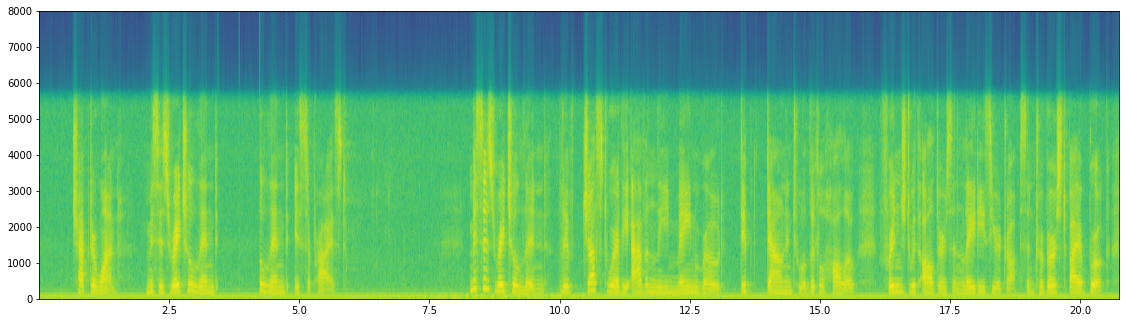

In [ ]:
def graph_spectrogram(wav_file):
    rate, data = wavfile.read(wav_file)
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    pxx, freqs, bins, im = ax.specgram(x=data, Fs=16000, noverlap=128, NFFT=256) # NFFT used to be 512, worked well supposedly 
    ax.axis('off')
    #fig.savefig('sp_xyz.png', dpi=300, frameon='false')

rate, data = wavfile.read("/content/drive/MyDrive/Work/MCRL/stutter/data/uclass/audio/F_0050_10y9m_1.flac")
fig,ax = plt.subplots(1)
fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
#ax.axis('off')
pxx, freqs, bins, im = ax.specgram(x=data, Fs=16000, noverlap=128, NFFT=256) # NFFT used to be 512, worked well supposedly 

rate2, data2 = wavfile.read("/content/drive/MyDrive/Work/MCRL/stutter/data/libristutter/partA/audio/103/1240/103-1240-0000.flac")
fig2,ax2 = plt.subplots(1)
fig2.subplots_adjust(left=0,right=1,bottom=0,top=1)
pxx, freqs, bins, im = ax2.specgram(x=data2, Fs=16000, noverlap=128, NFFT=256)
plt.show()
#ax.axis('off')
#graph_spectrogram("/content/drive/MyDrive/Work/MCRL/stutter/data/uclass/audio/M_0090_10y1m_1.wav")
#graph_spectrogram("/content/drive/MyDrive/Work/MCRL/stutter/data/libristutter/partA/audio/103/1240/103-1240-0000.flac")

In [ ]:
#@title # Model begins here


In [ ]:
#@title Random Transforms { display-mode: "form" }

"""
# these random transforms below can help generalize the model by introducing different shapes and sizes and such

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

# You'll also typically want to normalize images with transforms.Normalize. 
# You pass in a list of means and list of standard deviations, then the color channels are normalized like so:
  input[channel] = (input[channel] - mean[channel]) / std[channel]
"""

"""
# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(224),
                                     transforms.ToTensor()])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)
"""


In [ ]:
#@title Visualize Data { run: "auto", display-mode: "form" }
def visualize_data(input, title=None):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)

    if title is not None:
       plt.title(None) # remove titles

    plt.pause(0.001)  ## Here we are pausing a bit so that plots are updated

inputs_data, classes = next(iter(loaders_data['train']))

## This is the code for getting a batch of training data
out = torchvision.utils.make_grid(inputs_data)

## Here we are making a grid from batch
#visualize_data(out, title=[class_names[x] for x in classes])

In [ ]:
#@title WandB Training Visualizer and Analysis { form-width: "10%", display-mode: "both" }
!pip install wandb -qU
# Log in to your W&B account
import wandb
wandb.login()
#API key: 5b5a1032d2bef3510f30bf3e46923f62ec1b1ac2

     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 181 kB 73.3 MB/s 
     |████████████████████████████████| 158 kB 71.4 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 157 kB 66.8 MB/s 
     |████████████████████████████████| 157 kB 81.0 MB/s 
     |████████████████████████████████| 157 kB 53.7 MB/s 
     |████████████████████████████████| 157 kB 76.6 MB/s 
     |████████████████████████████████| 157 kB 73.8 MB/s 
     |████████████████████████████████| 157 kB 70.7 MB/s 
     |████████████████████████████████| 157 kB 91.7 MB/s 
     |████████████████████████████████| 156 kB 53.6 MB/s 


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
#@title Install Libraries { display-mode: "form" }
# Install Libraries
#!pip install pydub -qU
#!pip install wandb -qU
#!wandb login
#!pip install cloud-tpu-client==0.10 torch==1.12.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.12-cp37-cp37m-linux_x86_64.whl
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Import Libraries { run: "auto", display-mode: "form" }
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
import math
import time
import copy
import gc
plt.ion() 

import torch
import torch.nn as nn 
import torch.nn.functional as F

import torch.hub
from torch.utils.data import Subset

import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

#from torchsummary import summary
from torchinfo import summary

from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

import scipy.signal as signal
from scipy.io import wavfile
import soundfile as sf


# imports the torch_xla package -- TPU
#import torch_xla
#import torch_xla.core.xla_model as xm

In [ ]:
#@title SERN Class and Creation Methods { form-width: "10%" }
# SEResNet Class
# From: https://github.com/StickCui/PyTorch-SE-ResNet/blob/master/model/model.py

class SEResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(SEResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


class Bottleneck(nn.Module): # what is this ....
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        # SE
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_down = nn.Conv2d(
            planes * 4, planes // 4, kernel_size=1, bias=False)
        self.conv_up = nn.Conv2d(
            planes // 4, planes * 4, kernel_size=1, bias=False)
        self.sig = nn.Sigmoid()
        # Downsample
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out1 = self.global_pool(out)
        out1 = self.conv_down(out1)
        out1 = self.relu(out1)
        out1 = self.conv_up(out1)
        out1 = self.sig(out1)

        if self.downsample is not None:
            residual = self.downsample(x)

        res = out1 * out + residual
        res = self.relu(res)

        return res


def se_resnet50(**kwargs):
    """Constructs a SE-ResNet-50 model.
    Args:
        num_classes = 1000 (default)
    """
    model = SEResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    return model


def se_resnet101(**kwargs):
    """Constructs a SE-ResNet-101 model.
    Args:
        num_classes = 1000 (default)
    """
    model = SEResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model


def se_resnet152(**kwargs):
    """Constructs a SE-ResNet-152 model.
    Args:
        num_classes = 1000 (default)
    """
    model = SEResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model




In [ ]:
torch.cuda.empty_cache()
#del FNmodel

In [ ]:
#@title Dataloading & Hyperparams { run: "auto", form-width: "12%", display-mode: "both" }
# SERN Data & Dataloading for the 4-second snippet spectrograms, unchanged
# OVA dataloading
data_loc = "/content/drive/MyDrive/data/libriAll/" 

SERN_transform = transforms.Compose([transforms.ToTensor()]) # array of transformations necessary for ImageFolder & PyTorch

# hyperparameters
num_epochs = 30
learning_rate = 1e-1
num_layers = 1
batch_size = 16
LSTM_dropout = 0.2

# immutable, data-specific parameters for the audo images
input_size = 3 * 288 * 432 # number of features in each data point we are processing
sequence_length = 1 # size of each image we are processing
num_classes = 2
hidden_size = 2 # size of the output that we are generating

transforming_spec_data = {

    'train': transforms.Compose([
          transforms.ToTensor(),
    ]),

    'test': transforms.Compose([
          transforms.ToTensor(),
    
]),

}

# part = "A"

classes = ['0', '2', '3', '4', '5']
foc_class = '2' # class the model will focus on learning to classify
other_class = '-1'

# ovsa_data_loc = f"/content/drive/MyDrive/data/libri{part}{foc_class}va/" # {class _}va = class _ versus network, one vs all
ovsa_data_loc = f"/content/drive/MyDrive/data/libri{foc_class}va/" # {class _}va = class _ versus network, one vs all

os.makedirs(os.path.dirname(f'{ovsa_data_loc}'), exist_ok=True)
oc_train_dest = f'{ovsa_data_loc}train/a/' # other classes train destination
fc_train_dest = f'{ovsa_data_loc}train/f/' # other classes test destination
oc_test_dest = f'{ovsa_data_loc}test/a/'
fc_test_dest = f'{ovsa_data_loc}test/f/'

#os.makedirs(os.path.dirname(oc_train_dest), exist_ok=True)
#os.makedirs(os.path.dirname(fc_train_dest), exist_ok=True) 
#os.makedirs(os.path.dirname(oc_test_dest), exist_ok=True)
#os.makedirs(os.path.dirname(fc_test_dest), exist_ok=True)

import shutil, errno
from distutils.dir_util import copy_tree

def copy_r(src, dst):
  try:
    shutil.copytree(src, dst)
  except OSError as exc: # python >2.5
    if exc.errno in (errno.ENOTDIR, errno.EINVAL):
      shutil.copy(src, dst)
    else: raise


if len(os.listdir(ovsa_data_loc)) == 0:
  for other_class in classes:
    if other_class != foc_class: 
      oc_origin_train_loc = data_loc + "train/" + other_class + "/."
      oc_origin_test_loc = data_loc + "test/" + other_class + "/."
      copy_tree(oc_origin_train_loc, oc_train_dest)
      copy_tree(oc_origin_test_loc, oc_test_dest)
    else:
      fc_origin_train_loc = data_loc + "train/" + foc_class + "/."
      fc_origin_test_loc = data_loc + "test/" + foc_class + "/."
      copy_tree(fc_origin_train_loc, fc_train_dest)
      copy_tree(fc_origin_test_loc, fc_test_dest)


all_dataset_classes = {x: datasets.ImageFolder(os.path.join(ovsa_data_loc, x), 

                                           transforming_spec_data[x])

                   for x in ['train', 'test']}

# establish classes & their corresponding stutters from each database
lclasses = {
    '0' : 'c',
    '1' : 'i',
    '2' : 'sr',
    '3' : 'wr',
    '4' : 'pr',
    '5' : 'p'
}
uclasses = {
    '0' : 'c',
    '1' : 'i',
    '2' : 'sr',
    '3' : 'pwr',
    '4' : 'wr',
    '5' : 'pr',
    '6' : 'rv',
    '7' : 'p'
}

classes = ['f', 'a']


# select the indices of all other folders
datasets_images = {}

"""for key, dataset in all_dataset_classes.items():
  idx = [i for i in range(len(dataset)) if dataset.imgs[i][1] == dataset.class_to_idx[classes[0]] or dataset.imgs[i][1] == dataset.class_to_idx[classes[1]]]
  # build the appropriate subset
  datasets_images[key] = Subset(dataset, idx)
"""

for key, dataset in all_dataset_classes.items():
  idx =  [i for i in range(len(dataset))]
  datasets_images[key] = Subset(dataset, idx)

loaders_data = {x: torch.utils.data.DataLoader(datasets_images[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4) # what is num_workers?

               for x in ['train', 'test']}


sizes_datasets = {x: len(datasets_images[x]) for x in ['train', 'test']}

class_names = classes

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#xm.xla_device(devkind='TPU' )

In [ ]:
#@title Dataloading: Free-For-All Learning Class Network Setup { form-width: "10%", display-mode: "both" }
# SERN Data & Dataloading for the 4-second snippet spectrograms, unchanged
# 1v1v1v1v1v1 dataloading
data_loc = "/content/drive/MyDrive/data/imagesA/" 

SERN_transform = transforms.Compose([transforms.ToTensor()]) # array of transformations necessary for ImageFolder & PyTorch

# hyperparameters
num_epochs = 30
learning_rate = 1e-4
num_layers = 1
batch_size = 16
LSTM_dropout = 0.2

# immutable, data-specific parameters for the audo images
input_size = 3 * 288 * 432 # number of features in each data point we are processing
sequence_length = 1 # size of each image we are processing
num_classes = 5
hidden_size = 5 # size of the output that we are generating

transforming_spec_data = {

    'train': transforms.Compose([
          transforms.ToTensor(),
    ]),

    'test': transforms.Compose([
          transforms.ToTensor(),
    
]),

}

# part = "A"

classes = ['0', '2', '3', '4', '5']

all_dataset_classes = {x: datasets.ImageFolder(os.path.join(data_loc, x), 

                                           transforming_spec_data[x])

                   for x in ['train', 'test']}

# for lst_key in all_dataset_classes:
#   all_dataset_classes[lst_key] = np.array(all_dataset_classes[lst_key])

# establish classes & their corresponding stutters from each database
lclasses = {
    '0' : 'c',
    '1' : 'i',
    '2' : 'sr',
    '3' : 'wr',
    '4' : 'pr',
    '5' : 'p'
}
uclasses = {
    '0' : 'c',
    '1' : 'i',
    '2' : 'sr',
    '3' : 'pwr',
    '4' : 'wr',
    '5' : 'pr',
    '6' : 'rv',
    '7' : 'p'
}


# select the indices of all other folders
datasets_images = {}

"""for key, dataset in all_dataset_classes.items():
  idx = [i for i in range(len(dataset)) if dataset.imgs[i][1] == dataset.class_to_idx[classes[0]] or dataset.imgs[i][1] == dataset.class_to_idx[classes[1]]]
  # build the appropriate subset
  datasets_images[key] = Subset(dataset, idx)
"""
"""
for key, dataset in all_dataset_classes.items():
  idx =  [i for i in range(len(dataset))]
  datasets_images[key] = Subset(dataset, idx)
"""
for key, dataset in all_dataset_classes.items():
  idx =  [i for i in range(len(dataset))]
  datasets_images[key] = Subset(dataset, idx)

loaders_data = {x: torch.utils.data.DataLoader(datasets_images[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0) # what is num_workers?

               for x in ['train', 'test']}


sizes_datasets = {x: len(datasets_images[x]) for x in ['train', 'test']}

class_names = classes

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#xm.xla_device(devkind='TPU' )

In [ ]:
#@title CNNLSTM Classifier Class { form-width: "10%", display-mode: "form" }
# CNNLSTM class from https://medium.com/geekculture/recap-of-how-to-implement-lstm-in-pytorch-e17ec11b061e

# hyperparameters
num_layers = 1
batch_size = 8

# immutable, data-specific parameters for the audo images
input_size = 3 * 288 * 432 # number of features in each data point we are processing
sequence_length = 1 # size of each image we are processing
num_classes = 1
hidden_size = 512 # size of the output that we are generating
LSTM_dropout=0.1

class CNNLSTMClassifier(nn.Module):
    """def __init__(self, input_size, hidden_size, num_directions, num_layers, batch_size, no_classes):
        super(CNNLSTMClassifier, self).__init__()
        hidden_size = 6
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=1),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, input_size, 1),
            nn.ReLU(),
        )
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.hidden = self.init_hidden(batch_size, hidden_size, num_directions, num_layers)
        self.linear2 = nn.Linear(hidden_size, no_classes)"""
    def __init__(self, input_size, hidden_size, num_layers, batch_size, no_classes, num_directions=1):

        super(CNNLSTMClassifier, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=input_size, out_channels=64, kernel_size=1),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 512, kernel_size=1),
            nn.ReLU(),
        )
        #self.linear1 = nn.Linear(512, batch_size) # , 512)

        #self.lstm = nn.LSTM(batch_size, input_size, num_layers, batch_first=True, bidirectional=(num_directions == 2))
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=2, num_layers=num_layers,
                              bidirectional=(num_directions==2), batch_first=True).to(device)

        self.hidden = self.init_hidden(batch_size, 2, num_directions, num_layers)
        self.linear2 = nn.Linear(hidden_size*num_directions, no_classes)# hidden_size,
    

    def init_hidden(self, batch_size, hidden_size, num_directions, num_layers):
        return (torch.autograd.Variable(torch.zeros(num_directions*num_layers, batch_size, hidden_size).to(device)),
                torch.autograd.Variable(torch.zeros(num_directions*num_layers, batch_size, hidden_size).to(device)))

    def forward(self, x):
        print(f'x shape pre-conv1: {x.shape}')
        x = self.conv1(x)
        print(f'x shape post-conv1: {x.shape}')
        #print(f'x shape pre-conv2: {x.shape}')
        x = self.conv2(x)
        print(f'x shape post-conv2: {x.shape}')
        x = x.view(x.size(0), x.size(1), -1)
        x = x.permute(0, 2, 1)        
        print(self.hidden[0].shape)
        print(x.shape)
        x, (hn, cn) = self.lstm(x, self.hidden)
        y  = self.linear2(x[:, -1, :])
        return y, x, hn, cn

rnn = CNNLSTMClassifier(input_size, hidden_size, 2, num_layers, batch_size, num_classes)
rnn.to(device)

#inputs = torch.randn(batch_size, sequence_length, input_size).to(device)
inputs = torch.randn(batch_size, 3, 288*432).to(device) # inputs = torch.randn(batch_size, 3, 288, 432).to(device)
print(f'input: {inputs.shape}')
#summary(rnn, (3, 288, 432))
print("------------------------------------------------------------------")
#for _, [inputs, labels] in enumerate(loaders_data['test']):
#  inputs = inputs.to(device)
#  labels = labels.to(device)
output, output_lstm, hn, cn = rnn(inputs)

print(f'output: {output.size()}')
print(f'output lstm: {output_lstm.size()}')
print(f'hn: {hn.size()}')
print(f'cn: {cn.size()}')

In [ ]:
#@title FluentNet Recreated — SERN components { form-width: "10%" }
from typing import Type, Any, Callable, Union, List, Optional
import torch
import torch.nn as nn
from torch import Tensor
from torchvision import models


class SELayer(nn.Module):
    """From https://github.com/moskomule/senet.pytorch"""

    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


class SEBasicBlock(models.resnet.BasicBlock):
    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        reduction: int = 16,
    ) -> None:
        super().__init__(
            inplanes=inplanes,
            planes=planes,
            stride=stride,
            downsample=downsample,
            groups=groups,
            base_width=base_width,
            dilation=dilation,
            norm_layer=norm_layer,
        )
        self.se = SELayer(planes, reduction)

    def forward(self, x: Tensor) -> Tensor:
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class SEBottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # The ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        reduction: int = 16,
    ) -> None:
        """
        Note: Not inherited from torchvision.models.resnet.Bottleneck.__init__ due to replacing resnetv1 with resnetv1.5.
        Args:
            inplanes (int): _description_
            planes (int): _description_
            stride (int, optional): _description_. Defaults to 1.
            downsample (Optional[nn.Module], optional): _description_. Defaults to None.
            groups (int, optional): _description_. Defaults to 1.
            base_width (int, optional): _description_. Defaults to 64.
            dilation (int, optional): _description_. Defaults to 1.
            norm_layer (Optional[Callable[..., nn.Module]], optional): _description_. Defaults to None.
            reduction (int, optional): _description_. Defaults to 16.
        """
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width, stride, groups, dilation)  # Original ResNet implementation
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.se = SELayer(planes * 4, reduction)

    def forward(self, x: Tensor) -> Tensor:
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class SEResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[SEBasicBlock, SEBottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None " f"or a 3-element tuple, got {replace_stride_with_dilation}")
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, SEBottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, SEBasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[SEBasicBlock, SEBottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # x = self.avgpool(x)
        # x = torch.flatten(x, 1)
        # x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [ ]:
#@title FluentNet Recreated — Attention Mech. { form-width: "10%" }
import torch
from torch import nn
!pip install einops
from einops import rearrange


class Attention(nn.Module):
    """From https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py"""

    def __init__(self, dim, heads=8, dim_head=64, dropout=0.0):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(nn.Linear(inner_dim, dim), nn.Dropout(dropout)) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, "b n (h d) -> b h n d", h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        return self.to_out(out)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title FluentNet Recreated — Aggregate model { form-width: "10%" }
from typing import List

# FluentNet Recreation Code from: 
class FluentNetOneModel(nn.Module):
    def __init__(
        self,
        resnet_layers: List[int] = [2] * 8,
        resnet_block=SEBasicBlock,
        bilstm_dropout: float = 0.2, # 0.2 but then becomes 0.4 ... via first paper
        attention_dropout: float = 0.0,
        attention_dim_head: int = 128,
        hidden_size: int = 512,  # As per paper
    ):
        super().__init__()
        self.seresnet = SEResNet(resnet_block, layers=resnet_layers, num_classes=1)
        self.bilstm_layer = nn.LSTM(input_size=126, hidden_size=hidden_size, bidirectional=True, batch_first=True, num_layers=2, dropout=bilstm_dropout) # input_size used to be 1024
        self.attention_layer = Attention(dim=1024, dim_head=attention_dim_head, heads=1, dropout=attention_dropout)  # Global attention
        self.fc = nn.Linear(in_features=1024 * hidden_size, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor):
        out = self.seresnet(x)
        bil_in = out.flatten(start_dim=-2, end_dim=-1)
        bil_out, _ = self.bilstm_layer(bil_in)
        att_out = self.attention_layer(bil_out)
        out = att_out.flatten(1)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out


class FluentNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.sound_rep_model = FluentNetOneModel()
        self.word_rep_model = FluentNetOneModel()
        self.phrase_rep_model = FluentNetOneModel()
        #self.revision_model = FluentNetOneModel()
        #self.interjection_model = FluentNetOneModel()
        self.prolongation_model = FluentNetOneModel()
        self.clean_model = FluentNetOneModel() ## Added myself

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        sound_rep = self.sound_rep_model(x)
        word_rep = self.word_rep_model(x)
        phrase_rep = self.phrase_rep_model(x)
        #revision = self.revision_model(x)
        #interjection = self.interjection_model(x)
        prolongation = self.prolongation_model(x)
        clean = self.clean_model(x) ## Added myself

        #out = torch.stack([sound_rep, word_rep, phrase_rep, revision, interjection, prolongation], axis=-1)
        out = torch.stack([clean, sound_rep, word_rep, phrase_rep, prolongation], axis=-1)
        return out

In [ ]:
#@title FNR Training Method { form-width: "10%" }
# Training Method
def FNmodel_training(model, criterion, optimizer, scheduler, number_epochs=25):
    since = time.time()
    best_resmodel_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    accs = np.array([])
    losses = np.array([])
    for epochs in range(number_epochs): # training
        print('Epoch {}/{}'.format(epochs, number_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'test']: ## Here each epoch is having a training and validation phase
            if phase == 'train':
               model.train()  ## Here we are setting our model to training mode
            else:
               model.eval()   ## Here we are setting our model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            batch_num = 0

            for inputs, labels in loaders_data[phase]: ## Iterating over data.
                batch_num += 1
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() ## here we are making the gradients to zero

                with torch.set_grad_enabled(phase == 'train'): ## forwarding and then tracking the history if only in train
                    outputs = model(inputs)
                    #print(f'outputs pre: {outputs}')
                    outputs = outputs[:, 0, :]
                    #print(f'outputs post: {outputs}')
                    for row in outputs:
                      row = row[0]
                    _, preds = torch.max(outputs, 1)
                    # for a_pred in pred:
                    #   if a_pred != int(foc_class):
                    #     a_pred = 0
                    #   else: 
                    #     a_pred = 1
                    # print(f'''epoch: {epochs}; batch_num: {batch_num}
                    #       outputs: {outputs}
                    #       preds: {preds} 
                    #       labels: {labels}''')
                    loss = criterion(outputs, labels)
                    #wandb.log({"loss": loss.item()})
                    
                    wandb.watch(model)

                    if phase == 'train': # backward and then optimizing only if it is in training phase
                        loss.backward()
                        optimizer.step()
                    
                    gc.collect()

                running_loss += loss.detach().item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / sizes_datasets[phase]
            epoch_acc = running_corrects.double() / sizes_datasets[phase]
            

            if phase == 'train':
                scheduler.step()
                wandb.log({"learning_rate": scheduler.get_last_lr()})
                wandb.log({"train_acc": epoch_acc})
                wandb.log({"train_loss": epoch_loss})


            if phase == 'test':
              #accs = np.append(accs, epoch_acc.cpu())
              #losses = np.append(losses, epoch_loss)
              if epoch_acc > best_acc: ## deep copy the model
                best_acc = epoch_acc
                best_resmodel_wts = copy.deepcopy(model.state_dict())
              
              wandb.log({"test_loss": epoch_loss})
              wandb.log({"test_acc": epoch_acc})
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('\n\n')

    # Documenting/outputting results
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # fig, axes = plt.subplots(2)

    # ax = axes[0]
    # xaccs = range(len(accs))
    # ax.set_title("Acc over Epochs")
    # acc_plt = ax.plot(xaccs, accs, color="red", label="Accuracy")
    
    # ax = axes[1]
    # xlosses = range(len(losses))
    # ax.set_title("Loss over Epochs")
    # loss_plt = ax.plot(xlosses, losses, color="blue", label="Loss")

    # fig.tight_layout(pad=2)
    # fig.suptitle("Preformance over Epochs on Test Data")
    # plt.show()

    # load best model weights
    model.load_state_dict(best_resmodel_wts)
    return model


In [ ]:
#@title FNR training { form-width: "10%", display-mode: "both" }
# Training
import wandb

wandb.init(project="FluentNet Recreated")

FNdecayFreq = 100  
FNgamma = 0.1

wandb.config = {
  "learning_rate": learning_rate,
  "epochs": num_epochs,
  "batch_size": batch_size,
  "gamma": FNgamma,
  "decay_freq": FNdecayFreq,
  #"foc_class": foc_class
}

#print(f'Focus class: {foc_class}')

FNmodel = FluentNet().to(device)
FNcriterion = nn.CrossEntropyLoss().to(device)
FNoptim = optim.RMSprop(FNmodel.parameters(), lr=learning_rate)

FNlr_scheduler = lr_scheduler.MultiStepLR(FNoptim, milestones=range(num_epochs)[::FNdecayFreq], gamma=FNgamma)
FNmodel = FNmodel_training(FNmodel, FNcriterion, FNoptim, FNlr_scheduler, num_epochs)

#sample_img = tensor.randn(3, 288, 432)
#print(tisummary(FNmodel, (batch_size, 3, 288, 432)))

wandb: Currently logged in as: kosta. Use `wandb login --relogin` to force relogin


Epoch 0/29
----------
train Loss: 1.3494 Acc: 0.5414



test Loss: 1.2460 Acc: 0.6370



Epoch 1/29
----------
train Loss: 1.1450 Acc: 0.7177



test Loss: 1.1620 Acc: 0.6954



Epoch 2/29
----------
train Loss: 1.1057 Acc: 0.7472



test Loss: 1.1428 Acc: 0.7051



Epoch 3/29
----------
train Loss: 1.0857 Acc: 0.7805



test Loss: 1.1331 Acc: 0.7079



Epoch 4/29
----------
train Loss: 1.0679 Acc: 0.7947



test Loss: 1.1283 Acc: 0.7191



Epoch 5/29
----------
train Loss: 1.0589 Acc: 0.8155



test Loss: 1.1209 Acc: 0.7566



Epoch 6/29
----------
train Loss: 1.0465 Acc: 0.8328



test Loss: 1.1243 Acc: 0.7636



Epoch 7/29
----------
train Loss: 1.0400 Acc: 0.8482



test Loss: 1.1319 Acc: 0.7705



Epoch 8/29
----------
train Loss: 1.0300 Acc: 0.8504



test Loss: 1.1138 Acc: 0.7663



Epoch 9/29
----------
train Loss: 1.0252 Acc: 0.8610



test Loss: 1.1282 Acc: 0.7288



Epoch 10/29
----------
train Loss: 1.0166 Acc: 0.8735



test Loss: 1.1563 Acc: 0.7677



Epoch 11/29
--------

In [ ]:
print(summary(FluentNet(), (batch_size, 3, 288, 432)))

In [ ]:
#@title FN Testing { form-width: "10%" }
# Test FN
# def test_FluentNet(input):
#     model = FluentNet()
#     output = model.forward(input)
#     output = output.detach().numpy()
#     assert output.shape == torch.Size([input.shape[0], 1, 6]), "correct number of batches and classes outputted"
#     assert (output >= 0).all() and (output <= 1).all(), "sigmoid activation function included in model"


# for input in enumerate():
#   test_FluentNet(input[1])

#### 
vdata_loc = "/content/drive/MyDrive/data/uimages/train/"
uData = datasets.ImageFolder(vdata_loc, transform=transforms.Compose([transforms.ToTensor()]))

# select the indices of all other folders
datasets_images = {}
#lclasses = ['2', '3'] #['2', '2'] --> for ensuring its not randomly guessing, which it does not in fact seem to do
#uclasses = ['2', '4'] # '3' in libri is wr, '3' in uc is pwr, only '4' in uc is wr


classes = ['0', '2', '3', '4', '5']
#foc_class = '2' # class the model will focus on learning to classify

#u_ovsa_data_loc = f"/content/drive/MyDrive/data/uclass{foc_class}va/" # {class _}va = class _ versus network, one vs all

# os.makedirs(os.path.dirname(f'{u_ovsa_data_loc}'), exist_ok=True)
# oc_train_dest = f'{u_ovsa_data_loc}/a/' # other classes train destination
# fc_train_dest = f'{u_ovsa_data_loc}/f/' # other classes test destination
#oc_test_dest = f'{u_ovsa_data_loc}test/a/'
#fc_test_dest = f'{u_ovsa_data_loc}test/f/'

#os.makedirs(os.path.dirname(oc_train_dest), exist_ok=True)
#os.makedirs(os.path.dirname(fc_train_dest), exist_ok=True) 
#os.makedirs(os.path.dirname(oc_test_dest), exist_ok=True)
#os.makedirs(os.path.dirname(fc_test_dest), exist_ok=True)

# import shutil, errno
# from distutils.dir_util import copy_tree

# def copy_r(src, dst):
#   try:
#     shutil.copytree(src, dst)
#   except OSError as exc: # python >2.5
#     if exc.errno in (errno.ENOTDIR, errno.EINVAL):
#       shutil.copy(src, dst)
#     else: raise


# if len(os.listdir(u_ovsa_data_loc)) == 0:
#   for other_class in classes:
#     if other_class != foc_class: 
#       oc_origin_train_loc = vdata_loc + other_class + "/."
#       #oc_origin_test_loc = vdata_loc + "test/" + other_class + "/."
#       copy_tree(oc_origin_train_loc, oc_train_dest)
#       #copy_tree(oc_origin_test_loc, oc_test_dest)
#     else:
#       fc_origin_train_loc = vdata_loc + foc_class + "/."
#       #fc_origin_test_loc = vdata_loc + "test/" + foc_class + "/."
#       copy_tree(fc_origin_train_loc, fc_train_dest)
#       #copy_tree(fc_origin_test_loc, fc_test_dest)


for a_class in os.listdir(data_loc): 
  print(f'''
    Class: {a_class}
        A. Length of {a_class}: {len(os.listdir(f"{data_loc}/{a_class}"))}
        ''') # B. Length of test/{a_class}: {len(os.listdir(f"{u_ovsa_data_loc}test/{a_class}"))}


#idx = [i for i in range(len(dataset)) if dataset.imgs[i][1] == dataset.class_to_idx[classes[0]] or dataset.imgs[i][1] == dataset.class_to_idx[classes[1]]]
idx = [i for i in range(len(dataset))]
# build the appropriate subset
datasets_images['validation'] = Subset(dataset, idx)

validationLoader = torch.utils.data.DataLoader(datasets_images['validation'], batch_size=4, shuffle=True)

num_batches = 3

testing_model = FNmodel

#fig = plt.figure()
#class_pairs = ['2', '0'], ['2', '3'], ['2', '4'], ['2', '5']]
#u_accs = []

#print(f"Length of uimages/train/foc_class: {len(os.listdir(f'/content/drive/MyDrive/data/uimages/train/{foc_class}'))}")
#num_rest_imgs = 0
# for a_class in classes:
#   print(f"  Length of {a_class} folder: {len(os.listdir(f'/content/drive/MyDrive/data/uimages/train/{a_class}'))}")
#   if a_class != foc_class:
#     num_rest_imgs += len(os.listdir(f'/content/drive/MyDrive/data/uimages/train/{a_class}'))
# for a_class in classes:
#   print(f'  Length of {a_class} folder: {len(os.listdir(f"/content/drive/MyDrive/data/uimages/train/{a_class}"))}')

# print(f"Length of uimages/train/the rest: {num_rest_imgs}")
 
def model_usage(model, num_bchs):
  was_training = model.training
  num_bchs = num_bchs
  num_images = len(uData) * num_batches
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    num_c = 0
    num_t = 0
    for i in range(num_batches):
      for i, (inputs, labels) in enumerate(validationLoader):
                  inputs = inputs.to(device)
                  labels = labels.to(device)
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  for index in range(len(preds)):
                    #print(f'pred: {preds[index]} ; label: {labels[index]}')
                    num_t += 1
                    if preds[index] == labels[index]:
                      num_c += 1

      """for j in range(inputs.size()[0]):
          images_so_far += 1
          ax = plt.subplot(num_images//2, 2, images_so_far)
          ax.axis('off')
          ax.set_title('predicted: {}'.format(preds[j].item()))
          #print(f'correct: {labels[j]}')
          visualize_data(inputs.cpu().data[j])"""
    
    acc = num_c / num_t
    print(f'Model accuracy when distinguishing between classes provided from {vdata_loc}: {acc}')

model_usage(testing_model, num_batches)




    Class: train
        A. Length of train: 5
        

    Class: test
        A. Length of test: 5
        


NameError: ignored

In [ ]:
#@title SERN Model Training Method { run: "auto", form-width: "10%", display-mode: "form" }
def SERN_model_training(res_model, criterion, optimizer, scheduler, number_epochs=25):
    since = time.time()
    best_resmodel_wts = copy.deepcopy(res_model.state_dict())
    best_acc = 0.0
    accs = np.array([])
    losses = np.array([])
    for epochs in range(number_epochs): # training
        print('Epoch {}/{}'.format(epochs, number_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'test']: ## Here each epoch is having a training and validation phase
            if phase == 'train':
               res_model.train()  ## Here we are setting our model to training mode
            else:
               res_model.eval()   ## Here we are setting our model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in loaders_data[phase]: ## Iterating over data.
                #print(f'Labels: {labels}')
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() ## here we are making the gradients to zero

                with torch.set_grad_enabled(phase == 'train'): ## forwarding and then tracking the history if only in train
                     outputs = res_model(inputs)
                     _, preds = torch.max(outputs, 1)
                     #print(f' outputs:{outputs}')
                     #print(f'     preds: {preds}')
                     #print(labels)
                     loss = criterion(outputs, labels)
                     wandb.log({"loss": loss})
                     wandb.watch(res_model)

                     if phase == 'train': # backward and then optimizing only if it is in training phase
                         loss.backward()
                         optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / sizes_datasets[phase]
            epoch_acc = running_corrects.double() / sizes_datasets[phase]
            wandb.log({"epoch_loss": epoch_loss,
                       "epoch_acc": epoch_acc
                       })

            if phase == 'test':
              accs = np.append(accs, epoch_acc.cpu())
              losses = np.append(losses, epoch_loss)
              if epoch_acc > best_acc: ## deep copy the model
                best_acc = epoch_acc
                best_resmodel_wts = copy.deepcopy(res_model.state_dict())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    # Documenting/outputting results
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    fig, axes = plt.subplots(2)

    ax = axes[0]
    xaccs = range(len(accs))
    ax.set_title("Acc over Epochs")
    acc_plt = ax.plot(xaccs, accs, color="red", label="Accuracy")
    
    ax = axes[1]
    xlosses = range(len(losses))
    ax.set_title("Loss over Epochs")
    loss_plt = ax.plot(xlosses, losses, color="blue", label="Loss")

    fig.tight_layout(pad=2)
    fig.suptitle("Preformance over Epochs on Test Data")
    plt.show()

    # load best model weights
    res_model.load_state_dict(best_resmodel_wts)
    return res_model

In [ ]:
#@title Model Visualization { display-mode: "form" }
def model_visualization(res_model, num_images):
  was_training = res_model.training
  res_model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(loaders_data['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = res_model(inputs)
      _, preds = torch.max(outputs, 1)

    for j in range(inputs.size()[0]):
      images_so_far += 1
      ax = plt.subplot(num_images//2, 2, images_so_far)
      ax.axis('off')
      ax.set_title('predicted: {}'.format(class_names[preds[j]]))
      visualize_data(inputs.cpu().data[j])

      if images_so_far == num_images:
        res_model.train(mode=was_training)
        return res_model.train(mode=was_training)

In [ ]:
#@title SERN Loading and Finetuner Creation { run: "auto", form-width: "8%", display-mode: "both" }
# seresnet loading guided by https://github.com/moskomule/senet.pytorch
finetune_model = torch.hub.load(
    'moskomule/senet.pytorch',
    'se_resnet20',
    num_classes=num_classes)

num_ftrs = finetune_model.fc.in_features # fc = fully connected layer

print(f'Number of features: {num_ftrs}')

finetune_model.fc = nn.Linear(num_ftrs, num_classes)

finetune_model = finetune_model.to(device) # cast to GPU

criterion = nn.CrossEntropyLoss() # create loss function

finetune_optim = optim.RMSprop(finetune_model.parameters(), lr=learning_rate) # create optimizer: lr=1e-3 has worked well

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/moskomule/senet.pytorch/zipball/master" to /root/.cache/torch/hub/master.zip


Number of features: 64


wandb: Currently logged in as: kosta. Use `wandb login --relogin` to force relogin



    Class: 0
        A. Length of libriall/train/0: 2569
        B. Length of libriall/test/0: 586

    Class: 2
        A. Length of libriall/train/2: 1881
        B. Length of libriall/test/2: 365

    Class: 3
        A. Length of libriall/train/3: 1907
        B. Length of libriall/test/3: 382

    Class: 4
        A. Length of libriall/train/4: 1847
        B. Length of libriall/test/4: 384

    Class: 5
        A. Length of libriall/train/5: 1878
        B. Length of libriall/test/5: 401
Epoch 0/29
----------
train Loss: 0.4137 Acc: 0.8318
test Loss: 2.7550 Acc: 0.4169
Epoch 1/29
----------
train Loss: 0.2946 Acc: 0.8888
test Loss: 0.3796 Acc: 0.8239
Epoch 2/29
----------
train Loss: 0.2394 Acc: 0.9064
test Loss: 0.2845 Acc: 0.9089
Epoch 3/29
----------
train Loss: 0.2086 Acc: 0.9198
test Loss: 6.5814 Acc: 0.1723
Epoch 4/29
----------
train Loss: 0.1900 Acc: 0.9286
test Loss: 0.1798 Acc: 0.9348
Epoch 5/29
----------
train Loss: 0.1713 Acc: 0.9370
test Loss: 0.7061 Acc: 0.8281
Ep

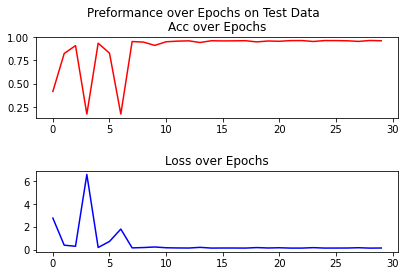

Data:

    Class: a
        A. Length of train/a: 8201
        B. Length of test/a: 1753

    Class: f
        A. Length of train/f: 1881
        B. Length of test/f: 365

        Location: /content/drive/MyDrive/data/libriAll/
        Distinguishing b/w types: 2 vs all
    Model:
        resnet_50
          num_epochs = 30
          learning_rate = 0.01
          num_layers = 1
          batch_size = 32
        

  decay frequency(decayFreq): 10
  decay factor(gamma): 0.1
  finetune_optim: 
RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.01
    lr: 1e-05
    momentum: 0
    weight_decay: 0
)
  finetune_model: 
 
    finetune_model = torch.hub.load(
      `moskomule/senet.pytorch`,
      `se_resnet20`,
      num_classes=1000
      )
  


In [ ]:
#@title SERN training & LR decay { form-width: "8%", display-mode: "both" }
import wandb

wandb.init(project="Transfer Learning SERN Stutter Classification")

wandb.config = {
  "learning_rate": learning_rate,
  "epochs": num_epochs,
  "batch_size": batch_size
}

decayFreq = 10
gamma = 0.1
exp_lr_scheduler = lr_scheduler.MultiStepLR(finetune_optim, milestones=range(num_epochs)[::decayFreq], gamma=gamma)
  
num_epochs = 30

for a_class in os.listdir(data_loc + "train/"): 
  print(f'''
    Class: {a_class}
        A. Length of libriall/train/{a_class}: {len(os.listdir(f"{data_loc}train/{a_class}"))}
        B. Length of libriall/test/{a_class}: {len(os.listdir(f"{data_loc}test/{a_class}"))}''')


SERN_model = SERN_model_training(finetune_model, criterion, finetune_optim, exp_lr_scheduler, num_epochs) # fine-tuned SERN model
print('Data:')
for a_class in os.listdir(ovsa_data_loc + "train/"): 
  print(f'''
    Class: {a_class}
        A. Length of train/{a_class}: {len(os.listdir(f"{ovsa_data_loc}train/{a_class}"))}
        B. Length of test/{a_class}: {len(os.listdir(f"{ovsa_data_loc}test/{a_class}"))}''')

print(f'''
        Location: {data_loc}
        Distinguishing b/w types: {foc_class} vs all
    Model:
        resnet_50
          num_epochs = {num_epochs}
          learning_rate = {learning_rate}
          num_layers = {num_layers}
          batch_size = {batch_size}
        ''')

print(f'''
  decay frequency(decayFreq): {decayFreq}
  decay factor(gamma): {gamma}
  finetune_optim: \n{finetune_optim}
  finetune_model: \n 
    finetune_model = torch.hub.load(
      `moskomule/senet.pytorch`,
      `se_resnet20`,
      num_classes=1000
      )
  ''')

In [ ]:
#model_visualization(SERNft_model, 2)
vdata_loc = "/content/drive/MyDrive/data/uimages/train/"
uData = datasets.ImageFolder(vdata_loc, transform=transforms.Compose([transforms.ToTensor()]))

# select the indices of all other folders
datasets_images = {}
#lclasses = ['2', '3'] #['2', '2'] --> for ensuring its not randomly guessing, which it does not in fact seem to do
#uclasses = ['2', '4'] # '3' in libri is wr, '3' in uc is pwr, only '4' in uc is wr


classes = ['0', '2', '3', '4', '5']
foc_class = '2' # class the model will focus on learning to classify

u_ovsa_data_loc = f"/content/drive/MyDrive/data/uclass{foc_class}va/" # {class _}va = class _ versus network, one vs all

os.makedirs(os.path.dirname(f'{u_ovsa_data_loc}'), exist_ok=True)
oc_train_dest = f'{u_ovsa_data_loc}/a/' # other classes train destination
fc_train_dest = f'{u_ovsa_data_loc}/f/' # other classes test destination
#oc_test_dest = f'{u_ovsa_data_loc}test/a/'
#fc_test_dest = f'{u_ovsa_data_loc}test/f/'

#os.makedirs(os.path.dirname(oc_train_dest), exist_ok=True)
#os.makedirs(os.path.dirname(fc_train_dest), exist_ok=True) 
#os.makedirs(os.path.dirname(oc_test_dest), exist_ok=True)
#os.makedirs(os.path.dirname(fc_test_dest), exist_ok=True)

import shutil, errno
from distutils.dir_util import copy_tree

def copy_r(src, dst):
  try:
    shutil.copytree(src, dst)
  except OSError as exc: # python >2.5
    if exc.errno in (errno.ENOTDIR, errno.EINVAL):
      shutil.copy(src, dst)
    else: raise


if len(os.listdir(u_ovsa_data_loc)) == 0:
  for other_class in classes:
    if other_class != foc_class: 
      oc_origin_train_loc = vdata_loc + other_class + "/."
      #oc_origin_test_loc = vdata_loc + "test/" + other_class + "/."
      copy_tree(oc_origin_train_loc, oc_train_dest)
      #copy_tree(oc_origin_test_loc, oc_test_dest)
    else:
      fc_origin_train_loc = vdata_loc + foc_class + "/."
      #fc_origin_test_loc = vdata_loc + "test/" + foc_class + "/."
      copy_tree(fc_origin_train_loc, fc_train_dest)
      #copy_tree(fc_origin_test_loc, fc_test_dest)


for a_class in os.listdir(u_ovsa_data_loc): 
  print(f'''
    Class: {a_class}
        A. Length of {a_class}: {len(os.listdir(f"{u_ovsa_data_loc}/{a_class}"))}
        ''') # B. Length of test/{a_class}: {len(os.listdir(f"{u_ovsa_data_loc}test/{a_class}"))}


#idx = [i for i in range(len(dataset)) if dataset.imgs[i][1] == dataset.class_to_idx[classes[0]] or dataset.imgs[i][1] == dataset.class_to_idx[classes[1]]]
idx = [i for i in range(len(dataset))]
# build the appropriate subset
datasets_images['validation'] = Subset(dataset, idx)

validationLoader = torch.utils.data.DataLoader(datasets_images['validation'], batch_size=4, shuffle=True)

num_batches = 3

testing_model = SERN_model

#fig = plt.figure()
#class_pairs = ['2', '0'], ['2', '3'], ['2', '4'], ['2', '5']]
#u_accs = []

print(f"Length of uimages/train/foc_class: {len(os.listdir(f'/content/drive/MyDrive/data/uimages/train/{foc_class}'))}")
num_rest_imgs = 0
for a_class in classes:
  print(f"  Length of {a_class} folder: {len(os.listdir(f'/content/drive/MyDrive/data/uimages/train/{a_class}'))}")
  if a_class != foc_class:
    num_rest_imgs += len(os.listdir(f'/content/drive/MyDrive/data/uimages/train/{a_class}'))

print(f"Length of uimages/train/the rest: {num_rest_imgs}")
 
def model_usage(model, num_bchs):
  was_training = model.training
  num_bchs = num_bchs
  num_images = len(uData) * num_batches
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    num_c = 0
    num_t = 0
    for i in range(num_batches):
      for i, (inputs, labels) in enumerate(validationLoader):
                  inputs = inputs.to(device)
                  labels = labels.to(device)
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  for index in range(len(preds)):
                    #print(f'pred: {preds[index]} ; label: {labels[index]}')
                    num_t += 1
                    if preds[index] == labels[index]:
                      num_c += 1

      """for j in range(inputs.size()[0]):
          images_so_far += 1
          ax = plt.subplot(num_images//2, 2, images_so_far)
          ax.axis('off')
          ax.set_title('predicted: {}'.format(preds[j].item()))
          #print(f'correct: {labels[j]}')
          visualize_data(inputs.cpu().data[j])"""
    
    acc = num_c / num_t
    print(f'Model accuracy when distinguishing between {foc_class} and the rest on the images provided from {vdata_loc}: {acc}')

model_usage(testing_model, num_batches)



    Class: a
        A. Length of a: 446
        

    Class: f
        A. Length of f: 408
        
Length of uimages/train/foc_class: 408
  Length of 0 folder: 175
  Length of 2 folder: 408
  Length of 3 folder: 6
  Length of 4 folder: 127
  Length of 5 folder: 138
Length of uimages/train/the rest: 446
Model accuracy when distinguishing between 2 and the rest on the images provided from /content/drive/MyDrive/data/uimages/train/: 0.9641170915958451


<Figure size 432x288 with 0 Axes>

In [ ]:
# Feature extraction, really extracting the weights from the ResNet model above

nodes, _ = get_graph_node_names(SERN_model)
print(nodes)

summary(SERN_model, (3, 288, 432))


feature_extractor = create_feature_extractor(
	SERN_model, return_nodes=['fc'])
# `out` will be a dict of Tensors, each representing a feature map
out = feature_extractor(torch.zeros(64, 3, 7, 7).cuda())
print(out['fc'].shape)
print(out['fc'])

['x', 'conv1', 'bn1', 'relu', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.se.size', 'layer1.0.se.getitem', 'layer1.0.se.getitem_1', 'layer1.0.se.getitem_2', 'layer1.0.se.getitem_3', 'layer1.0.se.avg_pool', 'layer1.0.se.view', 'layer1.0.se.fc.0', 'layer1.0.se.fc.1', 'layer1.0.se.fc.2', 'layer1.0.se.fc.3', 'layer1.0.se.view_1', 'layer1.0.se.expand_as', 'layer1.0.se.mul', 'layer1.0.add', 'layer1.0.relu_1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.se.size', 'layer1.1.se.getitem', 'layer1.1.se.getitem_1', 'layer1.1.se.getitem_2', 'layer1.1.se.getitem_3', 'layer1.1.se.avg_pool', 'layer1.1.se.view', 'layer1.1.se.fc.0', 'layer1.1.se.fc.1', 'layer1.1.se.fc.2', 'layer1.1.se.fc.3', 'layer1.1.se.view_1', 'layer1.1.se.expand_as', 'layer1.1.se.mul', 'layer1.1.add', 'layer1.1.relu_1', 'layer1.2.conv1', 'layer1.2.bn1', 'layer1.2.relu', 'layer1.2.conv2', 'layer1.2.bn2', 'layer1.2.se.size', 'layer1.2

In [ ]:
# LSTM Data & Dataloading for the 4-second snippet spectrograms, unchanged
data_loc = "/content/drive/MyDrive/data/imageTypes_0_st2/"

LSTM_transform = transforms.Compose([transforms.ToTensor()]) # array of transformations necessary for ImageFolder & PyTorch

# hyperparameters
num_epochs = 50
learning_rate = 1e-1
num_layers = 1
batch_size = 8
LSTM_dropout = 0.2

# immutable, data-specific parameters for the audo images
input_size = 3 * 288 * 432 # number of features in each data point we are processing
sequence_length = 1 # size of each image we are processing
num_classes = 2
hidden_size = num_classes # size of the output that we are generating


# audio spectrogram dataset
LSTM_train_dataset = datasets.ImageFolder(data_loc + "train/", transform=LSTM_transform)
LSTM_test_dataset = datasets.ImageFolder(data_loc + "test/", transform=LSTM_transform)

# dataloader
LSTM_train_dataloader = torch.utils.data.DataLoader(LSTM_train_dataset, batch_size=batch_size, shuffle=True)
LSTM_test_dataloader = torch.utils.data.DataLoader(LSTM_test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#@title Above LSTM class on MNIST data, converting this to stutter data
# Device configuration

#print("number of st5 images: " + str(len(sorted(os.listdir("/content/drive/MyDrive/data/images/train/5.0/")))))
#print("number of st4 images: " + str(len(sorted(os.listdir("/content/drive/MyDrive/data/images/train/4.0/")))))
#print("number of st3 images: " + str(len(sorted(os.listdir("/content/drive/MyDrive/data/images/train/3.0/")))))
#print("number of st2 images: " + str(len(sorted(os.listdir("/content/drive/MyDrive/data/images/train/2.0/")))))
#print("number of st0 images: " + str(len(sorted(os.listdir("/content/drive/MyDrive/data/images/train/0/")))))

'''
The below feature extraction was guided by: https://androidkt.com/feature-extraction-from-an-image-using-pre-trained-pytorch-model/

SEResNet feature extraction in development
from torchvision.models import resnet50, ResNet50_Weights
model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT) # gets stuck here

for param in model.parameters():
  param.requires_grad = False

num_ftrs = model.fc.in_features
 
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

loss_fn = nn.CrossEntropyLoss()
 
# The final step for feature extracting is to create an optimizer that only updates 
# the desired parameters. We know that all parameters that have requires_grad=True 
# should be optimized. Next, we make a list of such parameters and input this list to the SGD algorithm constructor.
params_to_update = []
for name,param in model.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
'''

print("length of train dataset: " + str(len(LSTM_train_dataset)))

train_losses = np.array([])

LSTM_model = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                              bidirectional=True, batch_first=True, bias=True, dropout=LSTM_dropout).to(device)

# Loss and optimizer
criterion = nn.MultiMarginLoss()
optimizer = torch.optim.AdamW(LSTM_model.parameters(), lr=learning_rate) 


# Train the model
print("\n<------------------------TRAINING----------------------->\n")
train_start = time.time()
n_total_steps = len(LSTM_train_dataloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(LSTM_train_dataloader):
        # origin shape: torch.Size([64, 3, 288, 432]) -> batch, features, h, w
        # resized:
        #print(images.shape)
        images = images.reshape(-1, sequence_length, input_size).to(device)
        #print(images.shape)
        labels = labels.to(device)
        
        # Forward pass
        output, x = LSTM_model(images)  # output, x before de-frankensteinization
        #print("output shape before [:, -1]: \n" + str(output.shape))
        output = output[:, -1]
        #print(output)
        #print("\n------------------------------------------------------\n")
        #print("train cycle " + str(epoch + 1))
        #print("output:\n")
        #print(output.shape)
        #print(output)
        #print("\n------------------------------------------------------\n")
        #print('x: \n' + str(x))
        #print("\n------------------------------------------------------\n")
        #print(labels)
        loss = criterion(output, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 1 == 0:
          print('output shape: \n' + str(output.shape))
          print('label shape: \n' + str(labels.shape))
          print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
          print("\n------------------------------------------------------\n")
      
    train_losses = np.append(train_losses, loss.item())

train_end = time.time()
train_time = train_end - train_start

In [ ]:

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
print("length of test dataset:" + str(len(LSTM_test_dataset)))

print("\n<------------------------TESTING----------------------->\n")
test_accs = np.array([])
test_start = time.time()
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  num_test_images = 0
  print("len test: " + str(len(LSTM_test_dataset)))
  for images, labels in LSTM_test_dataloader:
    num_test_images += len(images)
    images = images.reshape(-1, sequence_length, input_size).to(device)
    #print(images)
    labels = labels.to(device)
    
    print("images len: " + str(len(images)))
    print("labels len: " + str(len(labels)))
    print("labels: " + str(labels))
    output, x = LSTM_model(images)
    #print("outputs before guess distilled: " + str(output))
    _, guesses = torch.max(output, 2)
    #guesses = 0
    #print(output.shape) # -> tensor([[predictionTensor1], [predictionTensor2], ...], device='cuda')
    print("output len: " + str(len(output)))
    print("outputs after: " + str(guesses))
    print("\n------------------------------------------------------\n")
    currentImg = 0
    #guesses = torch.randn(len(output))
   
    #print(output)
    #print("guesses:" + str(guesses))
    '''for imgProbabilities in output:
      # max returns (value, index)
      # print(imgProbabilities)
      _, guess = torch.max(imgProbabilities, 1)
      print(guess)
      guesses[currentImg] = int(guess)
      currentImg+=1'''
    currentGuess = 0
    n_correct_in_cycle = 0
    n_in_cycle = len(guesses)
    for guess in guesses:
      #guess -= 1
      #print("guess:" + str(guess) + "; label: " + str(labels[currentGuess]))
      #print(guess[0])
      #print(labels[currentGuess])
      if guess[0] == labels[currentGuess] + 1:
        n_correct_in_cycle += 1
        n_correct += 1
      n_samples += 1
      currentGuess += 1
    acc_in_cycle = n_correct_in_cycle / n_in_cycle
    print(f'cycle acc: {acc_in_cycle}')
    test_accs = np.append(test_accs, acc_in_cycle)
    
test_end = time.time()
test_time =  test_end - test_start

print("\n\n---------------------------SETUP---------------------------")
print(f'''Data Transformations:
        {LSTM_transform}
    ''')
print(f'''Model: 
        model = nn.LSTM(input_size=input_size, 
        hidden_size=hidden_size, 
        num_layers=num_layers, 
        bidirectional=False, 
        batch_first=True, 
        bias=True, 
        dropout={LSTM_dropout}
      ).to(device)''')
print(f'''Parameters:
          num_epochs = {num_epochs}
          learning_rate = {learning_rate}
          num_layers = {num_layers}
          batch_size = {batch_size}
          ''')
print(f'''Times:
        Training: {train_time}
        Testing: {test_time}
      ''')

fig, axes = plt.subplots(2)

ax = axes[0]
xtest_accs = range(len(test_accs))
ax.set_title("Test Acc over Dataloader Chunks")
acc_plt = ax.plot(xtest_accs, test_accs, color="red", label="Accuracy")

ax = axes[1]
xtrain_losses = range(len(train_losses))
ax.set_title("Train Loss over Epochs")
loss_plt = ax.plot(xtrain_losses, train_losses, color="blue", label="Loss")

fig.tight_layout(pad=2)
fig.suptitle("Preformance over Epochs")
plt.show()

acc = 100.0 * n_correct / n_samples
print(f'\nAccuracy of the network on the {num_test_images} test images: {acc} %')
print("------------------------------------------------------\n\n")